## Predicting individual differnces with Connectome embeddings

Producing individual-level CE requires learning a compact vectorized representation of
 brain nodes and aligning the representations obtained from different individuals to
 the same latent space. Here we will demonstrate CE ability to preserve variance
 associated with age and to improve age estimation compare to the raw structural
 connectivity.


We focus on age here since it is a variable with strong relation to brain connectivity
(Faskowitz, Yan, Zuo, & Sporns, 2018), widespread effects on cognition and is openly
available within The Enhanced Nathan Kline Institute-Rockland Sample
(Nooner et al., 2012; http://fcon_1000.projects.nitrc.org/indi/enhanced/neurodata.html).
 In the paper we also estimate intelligence from CE, but this data requires an access
  request and cannot be shared here.



<img src="https://raw.githubusercontent.com/GidLev/cepy/master/examples/images/ce_individuals.png" alt="CE alignment"  width = 542 height = 283/>


First, lets import some relevant packages:

In [41]:
%%capture
!pip install -U scikit-learn
!pip install seaborn
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import rgb2hex
import numpy as np
import seaborn as sns
import pandas as pd
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.base import clone
from sklearn.metrics import explained_variance_score
from tqdm import tqdm

Download the relevant data:

In [30]:
%%capture
# aligned CEs (from the previous notebook
!wget -O NKI_200_schaefer_subjects_ce.npz 'https://github.com/GidLev/cepy/blob/master/examples/data/NKI_200_schaefer_subjects_ce.npz?raw=true';
ces_subjects = np.load('NKI_200_schaefer_subjects_ce.npz')['x']
print(ces_subjects.shape)

# structural connectivity matrices
!wget -O NKI_200_schaefer_sc_matrices.npz 'https://github.com/GidLev/cepy/blob/master/examples/data/NKI_200_schaefer_sc_matrices.npz?raw=true';
sc_matrices = np.load('NKI_200_schaefer_sc_matrices.npz')['matrices']
print(sc_matrices.shape)

# subject labels
!wget -O NKI_demographics.csv 'https://github.com/GidLev/cepy/blob/master/examples/data/NKI_demographics.csv?raw=true';
subject_labels = pd.read_csv('NKI_demographics.csv')
print(subject_labels.head(10))
subjects_test_bool = subject_labels['test_set']
subjects_ages = subject_labels['Calculated_Age']


Read node labels:

In [31]:
%%capture
# download
!wget -O schaefer200_yeo17_networks.csv 'https://github.com/GidLev/cepy/blob/master/examples/data/schaefer200_yeo17_networks.csv?raw=true';

# read into a dataframe
node_labels = pd.read_csv('schaefer200_yeo17_networks.csv', index_col = 0)

Calculate the cosine similarity among all embeddings vector pairs, summarized as the cosine matrix:

In [32]:
cosine_matrices = np.zeros((ces_subjects.shape[0], ces_subjects.shape[1], ces_subjects.shape[1]))

for subject_i in np.arange(ces_subjects.shape[0]):
    cosine_matrices[subject_i,...] = cosine_similarity(ces_subjects[subject_i,...])

We have three features types (inputs to the prediction model) to compare: 

* The raw structural connectivity (SC)

* The cosine similarity matrix (CM)

* The connectome embedding (CE)

Within the training set, we first construct a separate model for each node and compare across the three feature types:

In [33]:
num_nodes = ces_subjects.shape[1]
input_names = ['CE', 'Cosine matrix', 'Structural connectivity']

# create dataframe to store the results
df_ce, df_cm, df_sc = node_labels.copy(), node_labels.copy(), node_labels.copy()
df_ce['input_type'], df_cm['input_type'], df_sc['input_type'] = input_names
dfs = [df_ce, df_cm, df_sc]

# define the features (CE, CE cosine matrix, SC matrix) within the training set
x_ce = ces_subjects[~subjects_test_bool,...].copy()
x_cm = cosine_matrices[~subjects_test_bool,...].copy()
x_sc = sc_matrices[~subjects_test_bool,...].copy()

Now we normalize the age values and initiate an empty array to store the predictions:

In [34]:
# and the real and predicted labela - age
y = subjects_ages[~subjects_test_bool].values
y_mean, y_std = y.mean(), y.std()
y = (y - y_mean) / y_std
y_pred_cv = np.zeros((len(input_names), len(y), num_nodes))

Now we can start training the model using 5-fold cross validation:

In [35]:
kf = KFold(n_splits=5)
lm = LinearRegression() # we use a simple linear regression

for node_i in tqdm(np.arange(num_nodes)): # loop over all nodes
    # a boolean vector to remove the diagonal as a feature
    exclude_diag = np.ones(num_nodes, dtype=bool)
    exclude_diag[node_i] = False

    inputs = [x_ce[:,node_i,:], x_cm[:,node_i,exclude_diag], x_sc[:,node_i,exclude_diag]] # select a node
    inputs = [scale(x) for x in inputs] # standardize the inputs (mean = 0, std = 1)
    
    for input_i, (input_name, input_x, input_df) in enumerate(zip(input_names, inputs, dfs)): # loop over the three input types
        for ind_kf, (train_index, test_index) in enumerate(kf.split(input_x)): # the 5-fold iterator
            curr_lm = clone(lm)
            curr_lm.fit(input_x[train_index, :], y[train_index])
            y_pred_cv[input_i, test_index, node_i] = curr_lm.predict(input_x[test_index, :])
            
        # keep the pearson correlation coefficient between the real and predicted age    
        input_df.loc[node_i, 'correlation_coef'], _ = stats.pearsonr(y, y_pred_cv[input_i, :, node_i])

100%|██████████| 200/200 [01:05<00:00,  3.05it/s]


Plot the results:

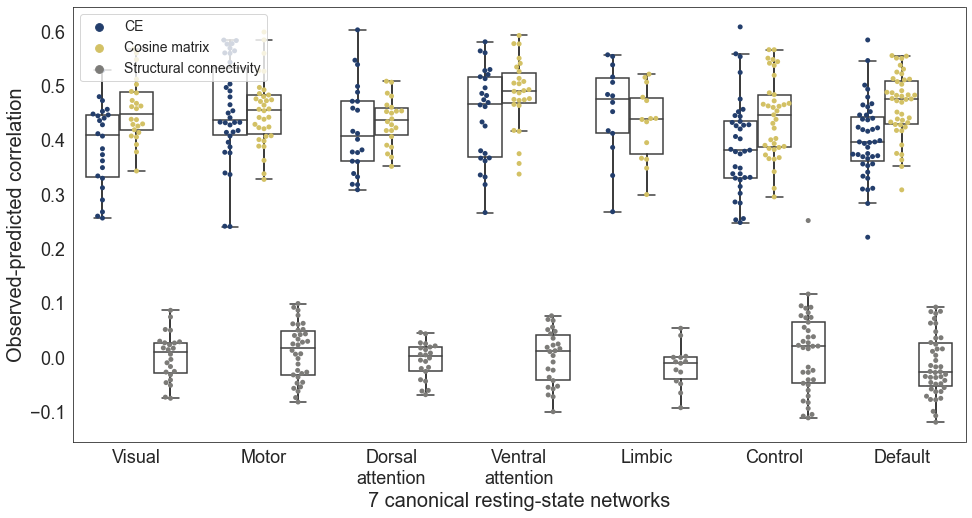

In [36]:
input_dfs = pd.concat(dfs) # concatanate all results dataframes


# define a color palette
colors_viridis = [[0.1359, 0.2414, 0.4251],
                  [0.8287, 0.7568, 0.3961],
                  [0.4861, 0.4826, 0.4707]]

c_palette = {'CE': rgb2hex(colors_viridis[0]), 
             'Cosine matrix': rgb2hex(colors_viridis[1]), 
             'Structural connectivity': rgb2hex(colors_viridis[2])}

# plot a joint swarm and box plot
sns.set_style("white")
fig, ax = plt.subplots(figsize=(16, 8)) 
sns.swarmplot(x="Yeo_7_nets", y='correlation_coef', hue = 'input_type', data=input_dfs, dodge=True,
              hue_order = input_names, palette=c_palette, size = 5, ax=ax)
sns.boxplot(x="Yeo_7_nets", y='correlation_coef', hue = 'input_type', data=input_dfs, hue_order = input_names,
            showcaps=True, boxprops={'facecolor': 'None'},
            showfliers=False, whiskerprops={'linewidth': 2}, ax=ax)
plt.xlabel("7 canonical resting-state networks", fontsize=20)
plt.ylabel('Observed-predicted correlation', fontsize=20)
ax.tick_params(labelsize=18)

# add a legend
ax.get_legend().remove()
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[3:], labels[3:], fontsize = 14, loc = 2);


Now let's train a model based on all nodes and test its performance on the left-out test set. As in the paper this would be conducted in two steps:


* First level models as we already trained on individual edges

* whole connectome, second-level models were created by training an ensemble of the nodal level predictions

Again we start by preparing the features and labels:

In [37]:
# initiate the prediction models
lm_first = LinearRegression()
lm_second = SGDRegressor(random_state = 1)

# define the features (SC matrix, CE cosine matrix, CE)
x_test_sc = sc_matrices[subjects_test_bool,...].copy()
x_test_cm = cosine_matrices[subjects_test_bool,...].copy()
x_test_ce = ces_subjects[subjects_test_bool,...].copy()

# get the real and predicted labels of the test set
y_test = subjects_ages[subjects_test_bool].values
y_test = (y_test - y_mean) / y_std
y_test_first_level = np.zeros((len(input_names), len(y_test), num_nodes))# and for the training set (without the cross validation)
y_test_pred = np.zeros((len(input_names), len(y_test)))



Train the nodal, first-level models: 

In [38]:
for node_i in tqdm(np.arange(num_nodes)): # loop over all nodes
    # a boolean vector to remove the diagonal as a feature
    exclude_diag = np.ones(num_nodes, dtype=bool)
    exclude_diag[node_i] = False

    inputs_test = [x_test_ce[:,node_i,:], x_test_cm[:,node_i,exclude_diag], x_test_sc[:,node_i,exclude_diag]] # select node
    inputs_test = [scale(x) for x in inputs_test] # standartize the input (mean = 0, std = 1)
    
    inputs = [x_ce[:,node_i,:], x_cm[:,node_i,exclude_diag], x_sc[:,node_i,exclude_diag]] # select node
    inputs = [scale(x) for x in inputs] # standartize the input (mean = 0, std = 1)
    
    for input_i, (input_train, input_test) in enumerate(zip(inputs, inputs_test)): # loop over the three input types
        curr_lm = clone(lm_first)
        curr_lm.fit(input_train, y)
        y_test_first_level[input_i, :, node_i] = curr_lm.predict(input_test)

100%|██████████| 200/200 [00:17<00:00, 11.22it/s]


And the whole connectome, second-level models: 

In [39]:
# create array to store the results
second_level_results_corr = [0] * 3     
second_level_results_ev = [0] * 3     


# now train the second-level model on the cross validated first-level results and produce predictions for the test set
for input_i in np.arange(len(input_names)): # loop over the three input types
    curr_lm = clone(lm_second)
    curr_lm.fit(y_pred_cv[input_i, ...], y)
    y_test_pred[input_i, :] = curr_lm.predict(y_test_first_level[input_i, ...])
    
    second_level_results_corr[input_i], _ = stats.pearsonr(y_test, y_test_pred[input_i, :])
    second_level_results_ev[input_i] = explained_variance_score(y_test, y_test_pred[input_i, :])

Now we plot the performance metrics obtained on the untouched test-set:

Connectome embedding model explained variance : 0.579
Cosine similarity model explained variance : 0.505
Structural connectivity model explained variance : -1.85e+75


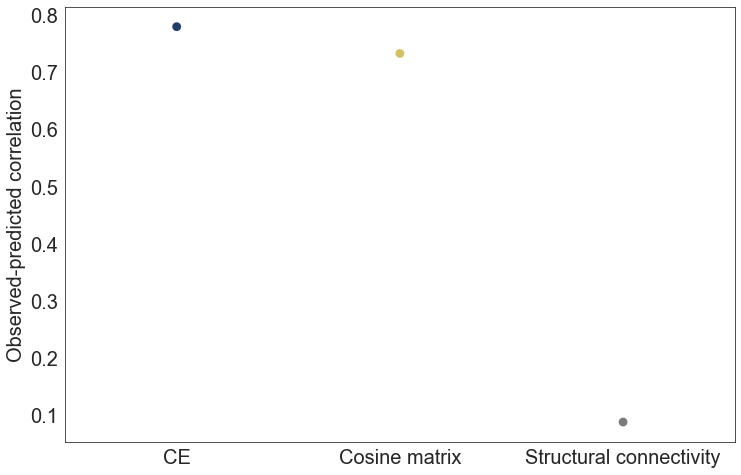

In [40]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(12, 8)) 

sns.pointplot(x=input_names, y=second_level_results_corr,ax=ax,
              palette=c_palette, size = 10)

ax.tick_params(labelsize = 20)
plt.xlabel("", fontsize=20)
plt.ylabel('Observed-predicted correlation', fontsize=20);

print('Connectome embedding model explained variance : {:.3}'.format(second_level_results_ev[0]))
print('Cosine similarity model explained variance : {:.3}'.format(second_level_results_ev[1]))
print('Structural connectivity model explained variance : {:.3}'.format(second_level_results_ev[2]))

### Referece

* Faskowitz, J., Yan, X., Zuo, X. N., & Sporns, O. (2018). Weighted Stochastic Block Models of the Human Connectome across the Life Span. Scientific Reports, 8(1), 12997. https://doi.org/10.1038/s41598-018-31202-1

* Nooner, K. B., Colcombe, S. J., Tobe, R. H., Mennes, M., Benedict, M. M., Moreno, A. L., … Milham, M. P. (2012). The NKI-Rockland Sample: A Model for Accelerating the Pace of Discovery Science in Psychiatry. Frontiers in Neuroscience, 6, 152. https://doi.org/10.3389/fnins.2012.00152